In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import geopandas as gpd
import shapely.wkt
from shapely.geometry import Polygon
import folium
from datetime import datetime

from envirocar import TrackAPI, DownloadClient, BboxSelector, TimeSelector, ECConfig

config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

In [2]:
## Helper functions

def random_color():
    r = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r()) 

def round_down(num, divisor):
    return np.floor(num / divisor) * divisor

def round_up(num, divisor):
    return np.ceil(num / divisor) * divisor  

<hr style="border:2px solid black"> </hr>

# Chemnitz

In [21]:
# Define bbox
xmin = 12.828
xmax = 13.001
ymin = 50.781
ymax = 50.877
bbox = BboxSelector([xmin, ymin, xmax, ymax])
# Define time interval 
start_time = '2020-07-06T00:00:00Z'
end_time = '2020-08-16T23:59:59Z'
time_interval = TimeSelector(start_time, end_time)
# Define number of tracks
num_results = 2000

## Request from api
track_df = track_api.get_tracks(bbox=bbox, time_interval=time_interval, num_results=num_results) 
out_name = "data/chemnitz/enviroCar/chemnitz" + datetime.today().strftime('_%Y-%m-%d_%H:%M:%S_') + str(num_results) + "tracks.csv"
track_df.to_csv(out_name.replace('chemnitz_', 'chemnitz_complete_'))

print(len(track_df['track.id'].unique()))
print(track_df.crs)
track_df.head()

1147
epsg:4326


id                 time                   geometry  \
0  5f27ed8705fa792e88ca77b8  2020-08-03T10:53:57  POINT (12.90414 50.83879)   
1  5f27ed8705fa792e88ca77ba  2020-08-03T10:54:09  POINT (12.90414 50.83887)   
2  5f27ed8705fa792e88ca77bb  2020-08-03T10:54:11  POINT (12.90427 50.83892)   
3  5f27ed8705fa792e88ca77bc  2020-08-03T10:54:13  POINT (12.90433 50.83899)   
4  5f27ed8705fa792e88ca77bd  2020-08-03T10:54:16  POINT (12.90439 50.83912)   

   Intake Temperature.value Intake Temperature.unit  Speed.value Speed.unit  \
0                 37.000000                       c     0.000000       km/h   
1                 36.999999                       c    19.613953       km/h   
2                 35.999999                       c    34.815029       km/h   
3                 35.000000                       c    45.999999       km/h   
4                 36.000000                       c    44.205584       km/h   

   GPS Bearing.value GPS Bearing.unit  Intake Pressure.value  ...  \
0         351.788911              deg              60.751648  ...   
1         354.239047              deg             153.997775  ...   
2           5.009578              deg             185.702700  ...   
3           8.181100              deg             129.272727  ...   
4          12.507014              deg              83.115681  ...   

  GPS VDOP.value  GPS VDOP.unit CO2.value  CO2.unit Consumption.value  \
0            NaN            NaN       NaN       NaN               NaN   
1            NaN            NaN       NaN       NaN               NaN   
2            NaN            NaN       NaN       NaN               NaN   
3            NaN            NaN       NaN       NaN               NaN   
4            NaN            NaN       NaN       NaN               NaN   

   Consumption.unit Calculated MAF.value  Calculated MAF.unit  \
0               NaN                  NaN                  NaN   
1               NaN                  NaN                  NaN   
2               NaN                  NaN                  NaN   
3               NaN                  NaN                  NaN   
4               NaN                  NaN                  NaN   

  track.appVersion  track.touVersion  
0              NaN               NaN  
1              NaN               NaN  
2              NaN               NaN  
3              NaN               NaN  
4              NaN               NaN  

[5 rows x 58 columns]

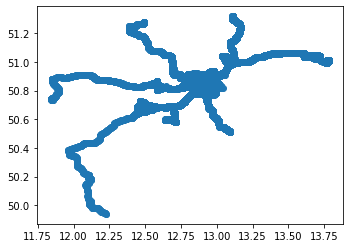

In [22]:
## Plot all tracks
bboxpoly = Polygon([(xmin, ymin,), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
bboxpoly_gdf = gpd.GeoDataFrame([1],geometry=[bboxpoly])

base = bboxpoly_gdf.plot(color='white', edgecolor='red')
track_df.plot(ax=base)

Before temporal filtering  96855
KW 28 15637
KW 29 8258
KW 30 12986
KW 31 10528


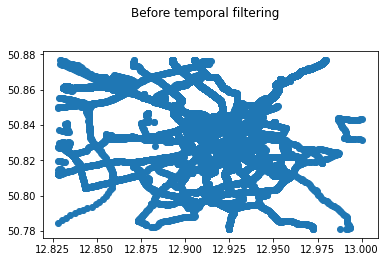

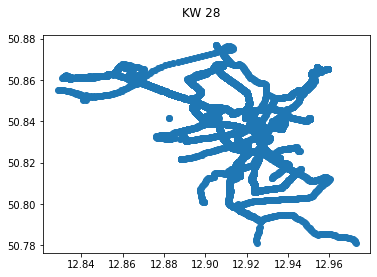

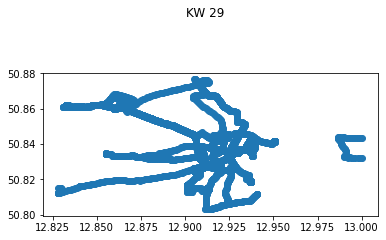

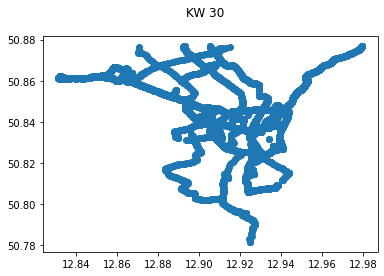

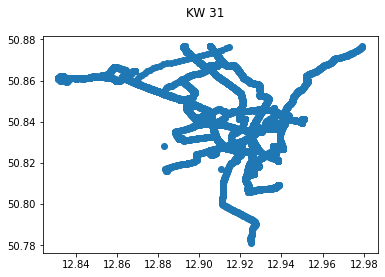

In [23]:
## Clip and filter tracks

# Reduce columns
columns = ['track.id','time','geometry','CO2.value','Speed.value']
track_df_sub = track_df[columns]
# Filter measurements with CO2
track_df_sub = track_df_sub.dropna(subset=['CO2.value'])
# Clip
track_df_sub = track_df_sub.reset_index(drop = True)
track_df_sub = gpd.clip(track_df_sub, bboxpoly_gdf)
# Plot before temporal filtering
f, ax = plt.subplots(1)
ax = track_df_sub.plot(ax=ax)
f.suptitle('Before temporal filtering')
print("Before temporal filtering ", len(track_df_sub))
track_df_sub.to_csv(out_name.replace('chemnitz_', 'chemnitz_reduced' + '_'))

# Filter time
# Example format: 01.08.2020 19:39:31 in csv / 2020-08-01T19:39:31 in DataFrame
KW = {"26": ["2020-06-22T00:00:00","2020-06-28T23:59:59"], "27": ["2020-06-29T00:00:00","2020-07-05T23:59:59"],
      "28": ["2020-07-06T00:00:00","2020-07-12T23:59:59"], "29": ["2020-07-13T00:00:00","2020-07-19T23:59:59"], 
      "30": ["2020-07-20T00:00:00","2020-07-26T23:59:59"], "31": ["2020-07-27T00:00:00","2020-08-02T23:59:59"],
      "32": ["2020-08-03T00:00:00","2020-08-09T23:59:59"], "33": ["2020-08-10T00:00:00","2020-08-16T23:59:59"],
      "34": ["2020-08-17T00:00:00","2020-08-23T23:59:59"], "all": ["2020-06-22T00:00:00","2020-08-23T23:59:59"]}
for kw in KW.keys():
    track_temp = track_df_sub[(track_df_sub['time'] > KW[kw][0]) & (track_df_sub['time'] < KW[kw][1])]
    print("KW", kw, len(track_temp))
    f, ax = plt.subplots(1)
    ax = track_temp.plot(ax=ax)
    f.suptitle("KW " + kw)
    track_temp.to_csv(out_name.replace('chemnitz_', 'chemnitz_KW' + kw + '_'))

In [8]:
## Store individual tracks separately
track_ids = track_df_sub['track.id'].unique()
tracks = []

for id in track_ids:
    tracks.append(track_df_sub[track_df_sub['track.id'] == id])

print(len(track_ids))

445


In [9]:
## Plot tracks
lat = 50.82
lng = 12.90

m = folium.Map(location=[lat, lng], zoom_start=13)

for track in tracks:
    lats = list(track['geometry'].apply(lambda coord: coord.y))
    lngs = list(track['geometry'].apply(lambda coord: coord.x))
    folium.PolyLine([coords for coords in zip(lats, lngs)], color=random_color()).add_to(m)
    
m

<hr style="border:2px solid black"> </hr>

# Hamm

In [10]:
# Define bbox
xmin = 7.720
xmax = 7.871
ymin = 51.643
ymax = 51.710
bbox = BboxSelector([xmin, ymin, xmax, ymax])
# Define time interval 
start_time = '2020-07-06T00:00:00Z'
end_time = '2020-08-16T23:59:59Z'
time_interval = TimeSelector(start_time, end_time)
# Define number of tracks
num_results = 2000

## Request from api
track_df = track_api.get_tracks(bbox=bbox, time_interval=time_interval, num_results=num_results) 
out_name = "data/hamm/enviroCar/hamm" + datetime.today().strftime('_%Y-%m-%d_%H:%M:%S_') + str(num_results) + "tracks.csv"
track_df.to_csv(out_name.replace('hamm_', 'hamm_complete_'))

print(len(track_df['track.id'].unique()))
print(track_df.crs)
track_df.head()

1000
epsg:4326


id                 time                  geometry  \
0  5f27dad305fa792e88bebb81  2020-08-03T09:22:00  POINT (7.85479 51.63307)   
1  5f27dad305fa792e88bebb83  2020-08-03T09:22:10  POINT (7.85451 51.63386)   
2  5f27dad305fa792e88bebb84  2020-08-03T09:22:15  POINT (7.85431 51.63428)   
3  5f27dad305fa792e88bebb85  2020-08-03T09:22:20  POINT (7.85392 51.63478)   
4  5f27dad305fa792e88bebb86  2020-08-03T09:22:25  POINT (7.85340 51.63529)   

   GPS Altitude.value GPS Altitude.unit  O2 Lambda Voltage ER.value  \
0          134.240665                 m                    1.961286   
1          130.759575                 m                    1.999844   
2          129.883003                 m                    1.271712   
3          129.275650                 m                    1.999783   
4          127.362848                 m                    1.999169   

  O2 Lambda Voltage ER.unit    Rpm.value Rpm.unit  MAF.value  ...  \
0                     ratio  1166.361444    u/min  14.469667  ...   
1                     ratio  1142.776119    u/min  14.824954  ...   
2                     ratio  1401.219768    u/min  23.809537  ...   
3                     ratio  1616.740573    u/min  22.986067  ...   
4                     ratio  1699.917647    u/min  23.050649  ...   

  GPS PDOP.value  GPS PDOP.unit GPS HDOP.value  GPS HDOP.unit GPS VDOP.value  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   GPS VDOP.unit track.appVersion  track.touVersion Energy Consumption.value  \
0            NaN              NaN               NaN                      NaN   
1            NaN              NaN               NaN                      NaN   
2            NaN              NaN               NaN                      NaN   
3            NaN              NaN               NaN                      NaN   
4            NaN              NaN               NaN                      NaN   

   Energy Consumption.unit  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  

[5 rows x 60 columns]

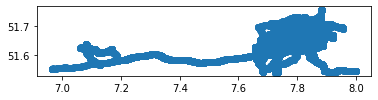

In [11]:
## Plot all tracks
bboxpoly = Polygon([(xmin, ymin,), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
bboxpoly_gdf = gpd.GeoDataFrame([1],geometry=[bboxpoly])

base = bboxpoly_gdf.plot(color='white', edgecolor='red')
track_df.plot(ax=base)

Before temporal filtering  57709
KW 28 10198
KW 29 10959
KW 30 11150
KW 31 8072


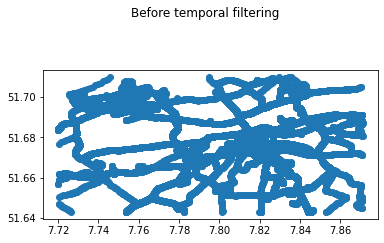

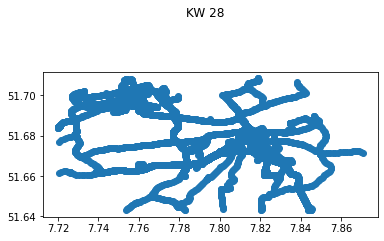

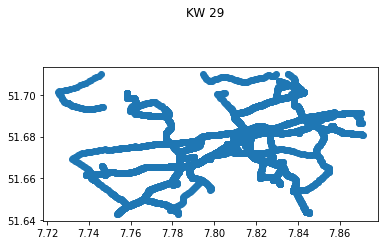

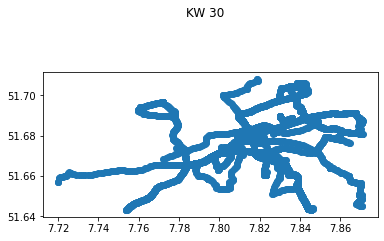

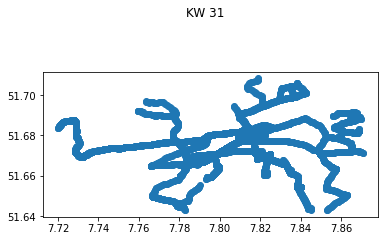

In [12]:
## Clip and filter tracks

# Reduce columns
columns = ['track.id','time','geometry','CO2.value','Speed.value']
track_df_sub = track_df[columns]
# Filter measurements with CO2
track_df_sub = track_df_sub.dropna(subset=['CO2.value'])
# Clip
track_df_sub = track_df_sub.reset_index(drop = True)
track_df_sub = gpd.clip(track_df_sub, bboxpoly_gdf)
# Plot before temporal filtering
f, ax = plt.subplots(1)
ax = track_df_sub.plot(ax=ax)
f.suptitle('Before temporal filtering')
print("Before temporal filtering ", len(track_df_sub))
track_df_sub.to_csv(out_name.replace('hamm_', 'hamm_reduced' + '_'))

# Filter time
# Example format: 01.08.2020 19:39:31 in csv / 2020-08-01T19:39:31 in DataFrame
KW = {"26": ["2020-06-22T00:00:00","2020-06-28T23:59:59"], "27": ["2020-06-29T00:00:00","2020-07-05T23:59:59"],
      "28": ["2020-07-06T00:00:00","2020-07-12T23:59:59"], "29": ["2020-07-13T00:00:00","2020-07-19T23:59:59"], 
      "30": ["2020-07-20T00:00:00","2020-07-26T23:59:59"], "31": ["2020-07-27T00:00:00","2020-08-02T23:59:59"],
      "32": ["2020-08-03T00:00:00","2020-08-09T23:59:59"], "33": ["2020-08-10T00:00:00","2020-08-16T23:59:59"],
      "34": ["2020-08-17T00:00:00","2020-08-23T23:59:59"], "all": ["2020-06-22T00:00:00","2020-08-23T23:59:59"]}
for kw in KW.keys():
    track_temp = track_df_sub[(track_df_sub['time'] > KW[kw][0]) & (track_df_sub['time'] < KW[kw][1])]
    print("KW", kw, len(track_temp))
    f, ax = plt.subplots(1)
    ax = track_temp.plot(ax=ax)
    f.suptitle("KW " + kw)
    track_temp.to_csv(out_name.replace('hamm_', 'hamm_KW' + kw + '_'))

In [13]:
## Store individual tracks separately
track_ids = track_df_sub['track.id'].unique()
tracks = []

for id in track_ids:
    tracks.append(track_df_sub[track_df_sub['track.id'] == id])

print(len(track_ids))

528


In [15]:
## Plot tracks
lat = 51.68
lng = 7.81

m = folium.Map(location=[lat, lng], zoom_start=13)

for track in tracks:
    lats = list(track['geometry'].apply(lambda coord: coord.y))
    lngs = list(track['geometry'].apply(lambda coord: coord.x))
    folium.PolyLine([coords for coords in zip(lats, lngs)], color=random_color()).add_to(m)
    
m

<hr style="border:2px solid black"> </hr>

# Krefeld

In [16]:
# Define bbox
xmin = 6.388
xmax = 6.669
ymin = 51.297
ymax = 51.392
bbox = BboxSelector([xmin, ymin, xmax, ymax])
# Define time interval 
start_time = '2020-07-06T00:00:00Z'
end_time = '2020-08-16T23:59:59Z'
time_interval = TimeSelector(start_time, end_time)
# Define number of tracks
num_results = 2000

## Request from api
track_df = track_api.get_tracks(bbox=bbox, time_interval=time_interval, num_results=num_results) 
out_name = "data/krefeld/enviroCar/krefeld" + datetime.today().strftime('_%Y-%m-%d_%H:%M:%S_') + str(num_results) + "tracks.csv"
track_df.to_csv(out_name.replace('krefeld_', 'krefeld_complete_'))

print(len(track_df['track.id'].unique()))
print(track_df.crs)
track_df.head()

517
epsg:4326


id                 time                  geometry  \
0  5f24323d05fa792e88a90832  2020-07-31T08:01:30  POINT (6.62863 51.34967)   
1  5f24323d05fa792e88a90834  2020-07-31T08:01:35  POINT (6.62797 51.34953)   
2  5f24323d05fa792e88a90835  2020-07-31T08:01:41  POINT (6.62730 51.34937)   
3  5f24323d05fa792e88a90836  2020-07-31T08:01:45  POINT (6.62662 51.34923)   
4  5f24323d05fa792e88a90837  2020-07-31T08:01:51  POINT (6.62597 51.34907)   

   GPS HDOP.value GPS HDOP.unit  Speed.value Speed.unit  Engine Load.value  \
0        0.551165     precision    35.000001       km/h          23.921568   
1        0.400000     precision    35.000000       km/h          25.201371   
2        0.430890     precision    35.733118       km/h          25.728468   
3        0.600000     precision    35.999999       km/h          11.782359   
4        0.600000     precision    35.157052       km/h          55.648325   

  Engine Load.unit  GPS Speed.value  ... track.appVersion  track.touVersion  \
0                %        34.163998  ...              NaN               NaN   
1                %        35.137570  ...              NaN               NaN   
2                %        35.333561  ...              NaN               NaN   
3                %        36.496885  ...              NaN               NaN   
4                %        33.774148  ...              NaN               NaN   

  Energy Consumption.value  Energy Consumption.unit Calculated MAF.value  \
0                      NaN                      NaN                  NaN   
1                      NaN                      NaN                  NaN   
2                      NaN                      NaN                  NaN   
3                      NaN                      NaN                  NaN   
4                      NaN                      NaN                  NaN   

   Calculated MAF.unit O2 Lambda Current ER.value  O2 Lambda Current ER.unit  \
0                  NaN                        NaN                        NaN   
1                  NaN                        NaN                        NaN   
2                  NaN                        NaN                        NaN   
3                  NaN                        NaN                        NaN   
4                  NaN                        NaN                        NaN   

  O2 Lambda Current.value  O2 Lambda Current.unit  
0                     NaN                     NaN  
1                     NaN                     NaN  
2                     NaN                     NaN  
3                     NaN                     NaN  
4                     NaN                     NaN  

[5 rows x 64 columns]

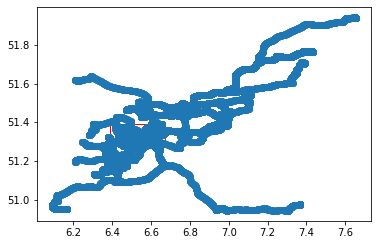

In [17]:
## Plot all tracks
bboxpoly = Polygon([(xmin, ymin,), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
bboxpoly_gdf = gpd.GeoDataFrame([1],geometry=[bboxpoly])

base = bboxpoly_gdf.plot(color='white', edgecolor='red')
track_df.plot(ax=base)

Before temporal filtering  11892
KW 28 737
KW 29 293
KW 30 402
KW 31 487


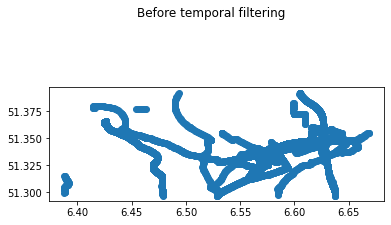

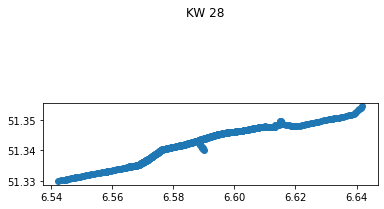

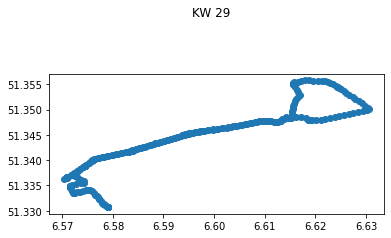

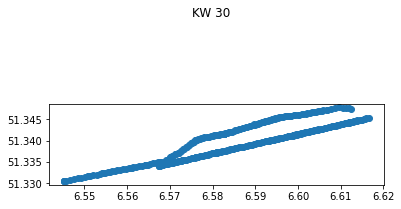

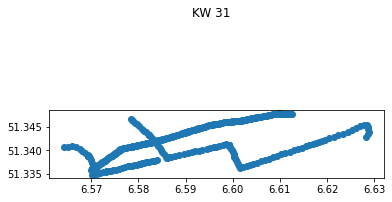

In [18]:
## Clip and filter tracks

# Reduce columns
columns = ['track.id','time','geometry','CO2.value','Speed.value']
track_df_sub = track_df[columns]
# Filter measurements with CO2
track_df_sub = track_df_sub.dropna(subset=['CO2.value'])
# Clip
track_df_sub = track_df_sub.reset_index(drop = True)
track_df_sub = gpd.clip(track_df_sub, bboxpoly_gdf)
# Plot before temporal filtering
f, ax = plt.subplots(1)
ax = track_df_sub.plot(ax=ax)
f.suptitle('Before temporal filtering')
print("Before temporal filtering ", len(track_df_sub))
track_df_sub.to_csv(out_name.replace('krefeld_', 'krefeld_reduced' + '_'))

# Filter time
# Example format: 01.08.2020 19:39:31 in csv / 2020-08-01T19:39:31 in DataFrame
KW = {"26": ["2020-06-22T00:00:00","2020-06-28T23:59:59"], "27": ["2020-06-29T00:00:00","2020-07-05T23:59:59"],
      "28": ["2020-07-06T00:00:00","2020-07-12T23:59:59"], "29": ["2020-07-13T00:00:00","2020-07-19T23:59:59"], 
      "30": ["2020-07-20T00:00:00","2020-07-26T23:59:59"], "31": ["2020-07-27T00:00:00","2020-08-02T23:59:59"],
      "32": ["2020-08-03T00:00:00","2020-08-09T23:59:59"], "33": ["2020-08-10T00:00:00","2020-08-16T23:59:59"],
      "34": ["2020-08-17T00:00:00","2020-08-23T23:59:59"], "all": ["2020-06-22T00:00:00","2020-08-23T23:59:59"]}
for kw in KW.keys():
    track_temp = track_df_sub[(track_df_sub['time'] > KW[kw][0]) & (track_df_sub['time'] < KW[kw][1])]
    print("KW", kw, len(track_temp))
    f, ax = plt.subplots(1)
    ax = track_temp.plot(ax=ax)
    f.suptitle("KW " + kw)
    track_temp.to_csv(out_name.replace('krefeld_', 'krefeld_KW' + kw + '_'))

In [19]:
## Store individual tracks separately
track_ids = track_df_sub['track.id'].unique()
tracks = []

for id in track_ids:
    tracks.append(track_df_sub[track_df_sub['track.id'] == id])

print(len(track_ids))

112


In [20]:
## Plot tracks
lat = 51.33
lng = 6.56

m = folium.Map(location=[lat, lng], zoom_start=13)

for track in tracks:
    lats = list(track['geometry'].apply(lambda coord: coord.y))
    lngs = list(track['geometry'].apply(lambda coord: coord.x))
    folium.PolyLine([coords for coords in zip(lats, lngs)], color=random_color()).add_to(m)
    
m